In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imresize
from scipy.misc import imsave
from scipy.ndimage import imread

### Load Image

In [3]:
M, N = 128, 128
imageSize = (M, N)

/anaconda3/envs/Titanic/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  if __name__ == '__main__':


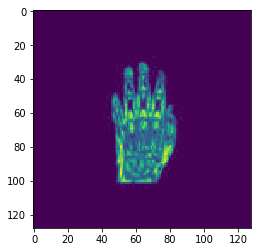

In [4]:
image = imread('Affine_HK/128x128_hand.jpg', flatten=True)
image = (image - np.mean(image)) / np.var(image)
image = image-np.min(image)
plt.imshow(image)

### Functions: 

In [5]:
def calLoss(moving, reference):
    return np.sum((moving-reference)**2)

In [6]:
def getCoorMatrix(imageShape):
    yShape, xShape = imageSize
    coorMatrix = np.asarray(np.meshgrid(np.arange(xShape), np.arange(yShape)))
    coorMatrix = np.rollaxis(coorMatrix, 0, 3)
    return coorMatrix
    

In [7]:
def getFourCorners(transformMatrix):
    # 1. calculat the coordinate matrix
    yShape, xShape = imageSize
    coorMatrix = getCoorMatrix(imageSize)
    onesMatrix = np.ones(imageSize).reshape(yShape, xShape, 1)
    coorMatrix = np.concatenate((coorMatrix, onesMatrix), axis=2)
    # 2. transformed coordinate matrix of transformed Matrix
    projectMatrix = np.dot(coorMatrix, transformMatrix.T) 
    
    # 3. set out of boundary points to zeros
    projectMatrix[projectMatrix<0] = 0
    x_matrix, y_matrix = projectMatrix[:,:,0], projectMatrix[:, :, 1]
    x_matrix[x_matrix>N-2] = 0 # maybe consider later
    y_matrix[y_matrix>M-2] = 0
    projectMatrix[:,:,0], projectMatrix[:, :, 1] = x_matrix.reshape(M,N), y_matrix.reshape(M,N)
    # 4. build nearby 4 point
    ULmatrix = np.floor(projectMatrix[:,:,0:2]).astype(int)
    DLmatrix = np.concatenate((np.floor(projectMatrix[:,:,0]).reshape(M, N, 1), \
                               np.floor(projectMatrix[:,:,1]+1).reshape(M, N, 1)), axis=2).astype(int)
    URmatrix = np.concatenate((np.floor(projectMatrix[:,:,0]+1).reshape(M, N, 1), \
                               np.floor(projectMatrix[:,:,1]).reshape(M, N, 1)), axis=2).astype(int)
    DRmatrix = np.floor(projectMatrix[:,:,0:2]+1).astype(int)
    cornerMatrixes = [ULmatrix, URmatrix, DLmatrix, DRmatrix] # UpLeft, UpRight, DownLeft, DownRight
    
    return cornerMatrixes, projectMatrix

<h3>Interpolate Method</h3>
<img src="img/interpolate.png" width="20%" height="20%">
<img src="img/interpolate_method.png" width="40%" height="40%">
<img src="img/image_gradient.png" width="30%" height="30%">

In [8]:
def biInterpolate(template, transformMatrix):
    cornerMatrixes, projectMatrix = getFourCorners(transformMatrix)
    kMatrix = [] # UpLeft, UpRight, DownLeft, DownRight interpolated corner image
    for i, matrix in enumerate(cornerMatrixes):
        new = template[matrix[:,:,1],matrix[:, :, 0]]
        kMatrix.append(new)
#     plt.imshow(kMatirx[0])
    xr1 = projectMatrix[:,:,0] - cornerMatrixes[0][:, :, 0]
    xr2 = projectMatrix[:,:,1] - cornerMatrixes[0][:, :, 1]
    k00, k01, k10, k11 = kMatrix[2], kMatrix[0], kMatrix[3], kMatrix[1]
    newImage = (1-xr1)*((1-xr2)*k01+xr2*k00)+xr1*((1-xr2)*k11+xr2*k10)
    delta_px = (1-xr2)*(k11-k01) + xr2*(k10-k00)
    delta_py = (1-xr1)*(k00-k01) + xr1*(k10-k11)    
    return newImage, delta_px, delta_py
    

In [9]:
def calGradient(reference, moving, dTx, dTy, lr):
    coorMatrix = getCoorMatrix(imageSize)
    x_coor, y_coor = np.split(coorMatrix, [1], axis=2)
    x_coor, y_coor = x_coor.squeeze(),  y_coor.squeeze()
    dw1 = 2*np.sum((moving - reference) * dTx * x_coor)
    dw2 = 2*np.sum((moving - reference) * dTx * y_coor)
    dw3 = 2*np.sum((moving - reference) * dTx)
    
    dw4 = 2*np.sum((moving - reference) * dTy * x_coor)
    dw5 = 2*np.sum((moving - reference) * dTy * y_coor)
    dw6 = 2*np.sum((moving - reference) * dTy)
    
    dw = np.array([[dw1, dw2, dw3],
                   [dw4, dw5, dw6],
                   [0  , 0,   1]])
    return dw


In [10]:
def gradientCheck(matrix, grad):
    epsilon = 1e-7
    thetaplus = matrix.copy()
    thetaplus[0][0] = thetaplus[0][0]+epsilon
    thetaminus = matrix.copy()
    thetaminus[0][0] -= epsilon
#     print(thetaplus,thetaminus)
    moving_plus, _, _ = biInterpolate(template, thetaplus)
    moving_minus, _, _ = biInterpolate(template, thetaminus)

    J_plus = calLoss(moving_plus, reference)                
    J_minus = calLoss(moving_minus, reference)              
#     print("J_plus", J_plus,"J_minus", J_minus)
    gradapprox = (J_plus - J_minus) / (2 * epsilon)          
    print("grad:", grad[0][0], "grad approx:", gradapprox)
    numerator = np.linalg.norm(grad[0][0] - gradapprox)                   
    denominator = np.linalg.norm(grad[0][0]) + np.linalg.norm(gradapprox)    
    difference = numerator / denominator                               
    print("difference: ",difference)
    return difference

### 1. create template image

Text(0, 0.5, 'y')

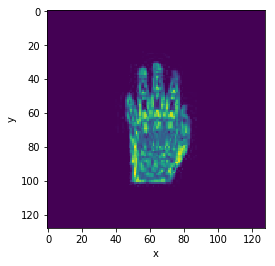

In [11]:
# initialize a zero template
template = image
# template = np.zeros((M, N))
# # draw a box on template
# template[5:55, 6:56] = 10
# template[7:20, 8:22] = 20
# template[60:100, 70:100] = 20
plt.imshow(template)
plt.xlabel("x")
plt.ylabel("y")

### 2. create reference image

In [12]:
reference = np.zeros(template.shape)
import math
angle = 10*math.pi/180.0
angle_sin = math.sin(angle)
angle_cos = math.cos(angle)
transformMatrix = np.array([[1.0, 0.0, 40.0],[0.0, 1.0, 0.0],[0.0, 0.0, 1.0]])


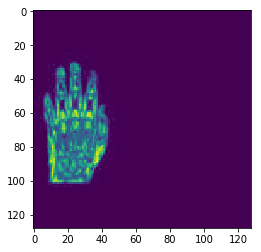

In [13]:
newImage, dTx, dTy = biInterpolate(template, transformMatrix) # May have some edge problem
reference = newImage
plt.imshow(newImage)

### 3. Gradient Descent

grad: -136.46832004779233 grad approx: -136.39085942429574
difference:  0.00028388498289285275
40.15309721674606
grad: -79.99511862936455 grad approx: -79.95504038404988
difference:  0.0002505670864091696
39.873629176006915
grad: -50.121253507070506 grad approx: -50.099560517935515
difference:  0.00021645193511976487
39.761877092959
grad: -33.72758707846462 grad approx: -33.7155049123794
difference:  0.00017914608788787085
39.70849143630785
grad: -24.50686755769058 grad approx: -24.49999680464998
difference:  0.00014019980935319498
39.67897072494584
grad: -19.220524571937464 grad approx: -19.216547286760033
difference:  0.00010347523848986757
39.660723380988195
grad: -16.13500379985977 grad approx: -16.132657876255507
difference:  7.27020020170783e-05
39.648445976575445
grad: -14.296380814323264 grad approx: -14.294963861516408
difference:  4.95588025999261e-05
39.63959302252488
grad: -13.170126303231921 grad approx: -13.169241981358937
difference:  3.357414891008307e-05
39.63280979076

KeyboardInterrupt: 

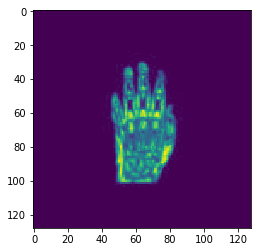

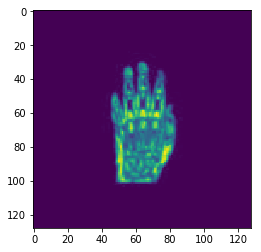

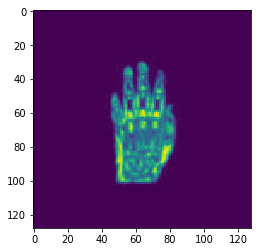

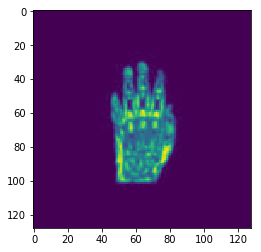

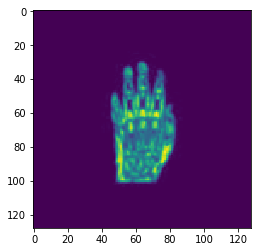

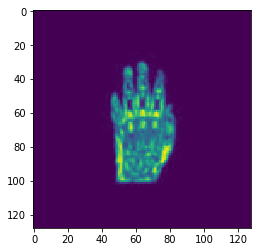

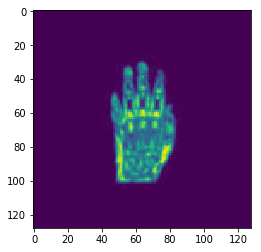

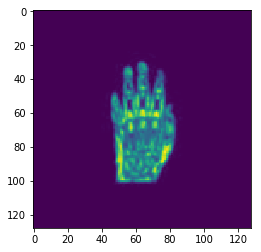

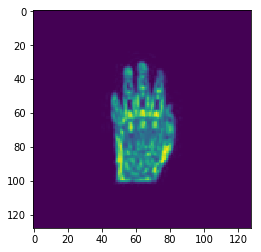

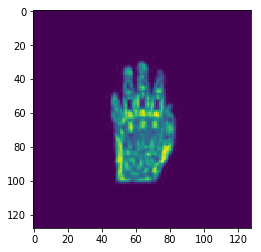

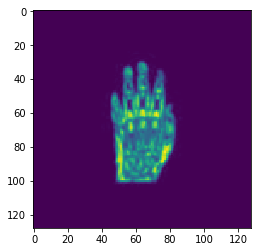

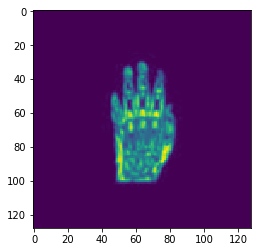

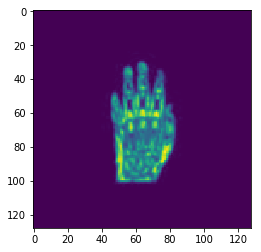

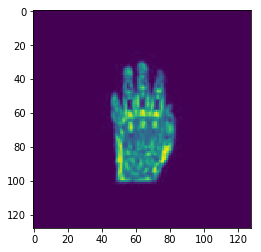

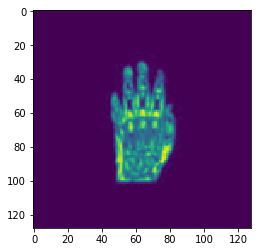

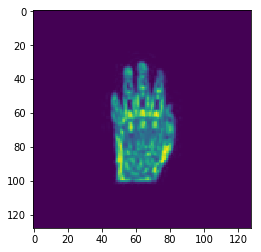

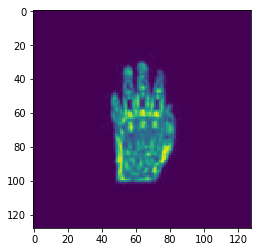

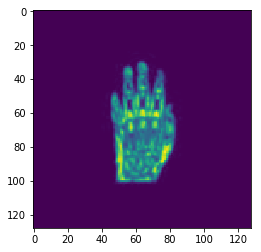

In [14]:
transMatrix = np.array([[1.0, 0.0, 0.0],[0.0, 1.0, 0.0],[0.0, 0.0, 1.0]])
lr = 1e-8
i = 0

losses = []

iteration = 40000
while i < iteration:
    moving, dTx, dTy = biInterpolate(template, transMatrix)
    delta_weights = calGradient(reference, moving, dTx, dTy, lr)
    transMatrix -= lr*delta_weights
    loss = calLoss(moving, reference)
    i += 1
    losses.append(loss)
    if i%1000 == 0:
        plt.figure(i//1000)
        plt.imshow(moving)
        gradientCheck(transMatrix, delta_weights)
        print(loss)
        



ValueError: x and y must have same first dimension, but have shapes (40000,) and (18496,)

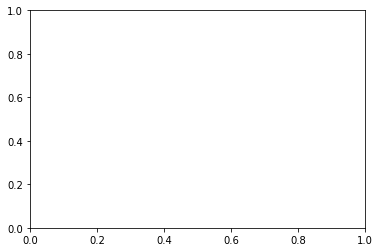

In [15]:
plt.plot(np.arange(iteration), losses)

Text(0.5, 1.0, 'moving')

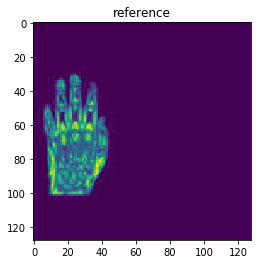

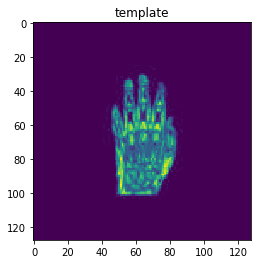

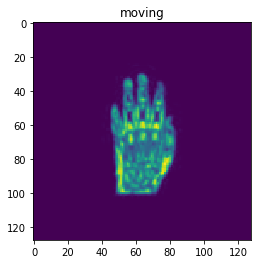

In [16]:
plt.figure(1)
plt.imshow(reference)
plt.title("reference")
plt.figure(2)
plt.imshow(template)
plt.title("template")
plt.figure(3)
plt.imshow(moving)
plt.title("moving")